In [2]:
from vidio.read import OpenCVReader
from multiprocessing import Queue, Process
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import h5py
import cv2
import os
from pathlib import Path
from bonpy import OpenCVMovieData
from matplotlib import pyplot as plt
from multicam_calibration import reorder_chessboard_corners

def opencv_from_numpy_bw(arr):
    return cv2.cvtColor(np.concatenate([arr[:, :, None],]*3, 2), cv2.COLOR_BGR2GRAY)

In [3]:
path = Path("/Users/vigji/Desktop/rig_test_videos/multicam_video_2024-04-04T16_07_59_cropped")
path.exists()

True

In [9]:
movie = "central"

movie_file = next(path.glob(f"*{movie}*.avi"))

movie_data = OpenCVMovieData(movie_file)

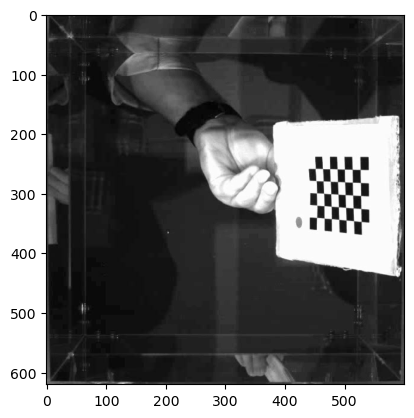

In [14]:
i = 3000
frames_slice = slice(i, i+50)  # for chessboard 1
# frames_slice = slice(14400, 14500)

image_array = movie_data[frames_slice]

plt.figure()
plt.imshow(image_array[0], cmap="gray")

In [15]:
image = opencv_from_numpy_bw(image_array[0])
subpix_winSize=(5, 5)

# cv image from numpy array:
# cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

ret, corners_approx = cv2.findChessboardCorners(
        image, board_shape, flags)
uvs = corners_approx[:, 0, :]

TypeError: 'NoneType' object is not subscriptable

In [16]:
def detect_chessboard(
    image,
    *,
    board_shape=(7, 10),
    subpix_winSize=(5, 5),
    scale_factor=1,
    adaptive_threshold=True,
    normalize_image=True,
    reorder=True,
    match_score_min_diff=0.2,
):
    """
    Detect corners of a chessboard and order them using a anchor point.

    To use this function, the chessboard should have a dark circle in the
    top-left corner when viewed from the font. The dark circle serves as an
    anchor: Points are ordered such that the point nearest the dark circle is
    indexed first, followed by the others in row-major order.::

        ●
        ██░░██░░██
        ░░██░░██░░
        ██░░██░░██


    Parameters
    ----------
    image : array
        Image to detect the chessboard in.

    board_shape : tuple (rows,columns)
        Number of squares in each dimension minus one. For example the board
        shown above would have shape (2,4).

    subpix_winSize : tuple (width,height), default=(5,5)
        Size of the window to use for subpixel refinement.

    scale_factor : float, default=1
        How much to shrink the image before initial chessboard detection.
        In all cases, the full resolution image is subsequently used for
        subpixel refinement.

    adaptive_threshold : bool, default=True
        Whether to use the flat `CALIB_CB_ADAPTIVE_THRESH` when applying
        `findChessboardCorners` in OpenCV.

    normalize_image : bool, default=True
        Whether to use the flat `CALIB_CB_NORMALIZE_IMAGE` when applying
        `findChessboardCorners` in OpenCV.

    reorder : bool, default=True
        Whether to reorder the points using an anchor.

    match_score_min_diff : float, default=0.2
        Minimum difference between the best and second-best match score. If the
        difference is less than this, then the anchor point is ambiguous and
        the detection is rejected.


    Returns
    -------
    uvs: array of shape (N,2) or None
        Either an array of corner coordinates or None if no board was found.

    match_scores : array of shape (4,)
        Sorted template-matching correlations for the four possible anchor
        points locations. Only returned if `reorder=True`.
    """
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    flags = (
        cv2.CALIB_CB_FAST_CHECK
        + cv2.CALIB_CB_ADAPTIVE_THRESH * adaptive_threshold
        + cv2.CALIB_CB_NORMALIZE_IMAGE * normalize_image
    )
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if scale_factor != 1:
        resized_image = cv2.resize(
            image, None, fx=scale_factor, fy=scale_factor
        )
    else:
        resized_image = image

    ret, corners_approx = cv2.findChessboardCorners(
        resized_image, board_shape, flags
    )

    if ret:
        corners_approx = corners_approx / scale_factor
        uvs = cv2.cornerSubPix(
            image, corners_approx, subpix_winSize, (-1, -1), criteria
        ).squeeze()

        if reorder:
            uvs, match_scores, _ = reorder_chessboard_corners(
                image, uvs, board_shape, 
            )
            # if match_scores[0] - match_scores[1] < match_score_min_diff:
            #     return None
            # else:
            return uvs, match_scores
        else:
            return uvs
    else:
        return None
    
def _generate_chessboard_anchor_template(size):
    """Generate a white square with a black circle in the top-left corner."""
    template = np.ones((size, size), dtype=np.uint8) * 255
    template = cv2.circle(template, (size // 4, size // 4), size // 4, 0, -1)
    return template

def _generate_custom_chessboard_anchor_template(size):
    """Generate a white square with a black circle in the top-left corner."""
    template = np.ones((size, size), dtype=np.uint8) * 255
    r = size // 8
    template = cv2.circle(template, ((size // 4), size // 4), r, 0, -1)
    # add square
    template = cv2.rectangle(template, (size // 2, size // 2), (size, size), 0, -1)
    return template

def _extract_region(image, source_pts, target_pts, template):
    """Extract a region of an image that will be matched to a template."""
    M = cv2.getPerspectiveTransform(source_pts, target_pts)
    warped_image = cv2.warpPerspective(image, M, template.shape[:2][::-1])
    return warped_image

def _match_to_template(image, all_source_pts, target_pts, template):
    """Compute correlation between a template and a region of an image."""
    match_scores, regions = [], []
    for source_pts in all_source_pts:
        region = _extract_region(image, source_pts, target_pts, template)
        if np.std(region) > 0:
            match_score = np.corrcoef(region.ravel(), template.ravel())[0, 1]
        else:
            match_score = 0
        match_scores.append(match_score)
        regions.append(region)
    return match_scores, regions

def homogeneous_to_euclidean(x_homogenous):
    """
    Convert homogenous coordinates to Euclidean coordinates

    ..math::

        (x_1,...,x_d, z) \mapsto (x_1/z,...,x_d/z)

    Parameters
    ----------
    x_homogenous : array of shape (...,d+1)
        Homogenous coordinates.

    Returns
    -------
    x_euclidean : array of shape (...,d)
        Euclidean coordinates.
    """
    x_euclidean = x_homogenous[..., :-1] / x_homogenous[..., -1:]
    return x_euclidean

def euclidean_to_homogenous(x_euclidean):
    """
    Convert Euclidean coordinates to homogenous coordinates

    ..math::

        (x_1,...,x_d) \mapsto (x_1,...,x_d, 1)

    Parameters
    ----------
    x_euclidean : array of shape (...,d)
        Euclidean coordinates.

    Returns
    -------
    x_homogenous : array of shape (...,d+1)
        Homogenous coordinates.
    """
    padding = np.ones((*x_euclidean.shape[:-1], 1))
    x_homogenous = np.concatenate((x_euclidean, padding), axis=-1)
    return x_homogenous


def extend_grid(uv_grid, extend_rows, extend_cols):
    """
    Given (u,v) coordinates from a chessboard detection in an image, simulate
    the coordinates of an enlarged chessboard using a homography transform.

    Parameters
    ----------
    uv_grid : array of shape (rows,cols,2)
        Grid of (u,v) coordinates (e.g. representing chessboard vertices).

    extend_rows : int
        Number of rows to extend by in each direction.

    extend_cols : int
        Number of columns to extend by in each direction.

    Returns
    -------
    extended_uv_grid : array of shape (rows+2*extend_rows,cols+2*extend_cols,2)
        Extended grid of (u,v) coordinates.
    """
    rows = uv_grid.shape[0] + 2 * extend_rows
    cols = uv_grid.shape[1] + 2 * extend_cols

    xy_grid_full = np.mgrid[0:cols, 0:rows].T
    xy_grid = xy_grid_full[extend_rows:-extend_rows, extend_cols:-extend_cols]

    H, _ = cv2.findHomography(xy_grid.reshape(-1, 2), uv_grid.reshape(-1, 2))

    extended_uv_grid = homogeneous_to_euclidean(
        euclidean_to_homogenous(xy_grid_full.reshape(-1, 2)) @ H.T
    ).reshape(xy_grid_full.shape)

    return extended_uv_grid

def reorder_chessboard_corners(image, uvs, board_shape, template_size=40):
    """
    Reorder chessboard points using an anchor point. See
    py:func:`multicam_calibration.detection.detect_chessboard` for details.

    Parameters
    ----------
    image : array
        Image that the chessboard was detected in.

    uvs : array of shape (N,2)
        Coordinates of the chessboard points.

    board_shape : tuple (rows,columns)
        Shape of the chessboard (number of squares in each dimension).

    template_size : int, default=40
        Size of template to generate.

    Returns
    -------
    reordered_uvs: array of shape (N,2)
        Reordered coordinates of the chessboard points.
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    uv_grid = uvs.reshape(board_shape[1], board_shape[0], 2)
    ext = extend_grid(uv_grid, 3, 1)

    all_source_pts = [
        np.float32([[ext[2, 0], ext[0, 0], ext[0, 2], ext[2, 2]]]),
        np.float32([[ext[0, -3], ext[0, -1], ext[2, -1], ext[2, -3]]]),
        np.float32([[ext[-3, -1], ext[-1, -1], ext[-1, -3], ext[-3, -3]]]),
        np.float32([[ext[-1, 2], ext[-1, 0], ext[-3, 0], ext[-3, 2]]]),
    ]

    s = 40  # size of anchor template
    template = _generate_custom_chessboard_anchor_template(s)
   #  template = _generate_chessboard_anchor_template(s)
    target_pts = np.float32([[0, s], [0, 0], [s, 0], [s, s]])
    match_scores, regions = _match_to_template(
        image, all_source_pts, target_pts, template
    )

    # Reorder points so best match is in top-left corner
    if np.argmax(match_scores) in [2, 3]:  # best match is in bottom row
        uv_grid = uv_grid[::-1, :]
    if np.argmax(match_scores) in [1, 2]:  # best match is in right column
        uv_grid = uv_grid[:, ::-1]

    uvs_reordered = uv_grid.reshape(-1, 2)
    sorted_match_scores = np.sort(match_scores)[::-1]
    vis_info = (all_source_pts, regions, template, match_scores)
    return uvs_reordered, sorted_match_scores, vis_info


In [20]:
ret

False

In [23]:
adaptive_threshold = True
normalize_image = True
board_shape = 5, 7

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = (
        cv2.CALIB_CB_FAST_CHECK
        + cv2.CALIB_CB_ADAPTIVE_THRESH * adaptive_threshold
        + cv2.CALIB_CB_NORMALIZE_IMAGE * normalize_image
    )

image = image_array[0]
scale_factor = 1

ret, corners_approx = cv2.findChessboardCorners(
        image, board_shape, flags
    )

corners_approx = corners_approx / scale_factor
uvs = cv2.cornerSubPix(
    image, corners_approx, subpix_winSize, (-1, -1), criteria
).squeeze()

uvs, match_scores, _ = reorder_chessboard_corners(
                image, uvs, board_shape, 
            )

In [24]:
image = image_array[0]
extend_rows = 3
extend_cols = 1

uv_grid = uvs.reshape(board_shape[1], board_shape[0], 2)
# ext = extend_grid(uv_grid, 1, 1)

rows = uv_grid.shape[0] + 2 * extend_rows
cols = uv_grid.shape[1] + 2 * extend_cols

xy_grid_full = np.mgrid[0:cols, 0:rows].T
xy_grid = xy_grid_full[extend_rows:-extend_rows, extend_cols:-extend_cols]

H, _ = cv2.findHomography(xy_grid.reshape(-1, 2), uv_grid.reshape(-1, 2))

ext = homogeneous_to_euclidean(
    euclidean_to_homogenous(xy_grid_full.reshape(-1, 2)) @ H.T
).reshape(xy_grid_full.shape)

print("xy_grid shape: ", xy_grid.shape)
print("uv_grid shape: ", uv_grid.shape)

xy_grid shape:  (7, 5, 2)
uv_grid shape:  (7, 5, 2)


In [25]:
H, _ = cv2.findHomography(xy_grid.reshape(-1, 2), uv_grid.reshape(-1, 2))
extended_uv_grid_mine = cv2.perspectiveTransform(np.array([xy_grid_full.reshape(-1, 2)], dtype=float), H)[0]

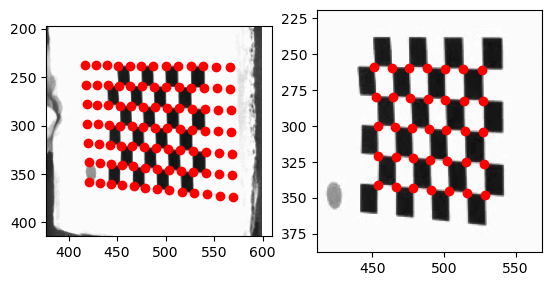

In [26]:
toplot = np.stack([ext[:, :, 0].flatten(), ext[:, :, 1].flatten()]).T
pad = 40
f, axs = plt.subplots(1, 2)
for i, data in enumerate([toplot, uvs]):
    axs[i].imshow(image_array[0], cmap="gray")
    axs[i].scatter(data[:, 0], data[:, 1], c="r")
    axs[i].set(xlim =(data[:, 0].min()-pad, data[:, 0].max()+pad), 
       ylim=(data[:, 1].max()+pad, data[:, 1].min()-pad))
# 
#axs[0].scatter(toplot[:, 0], toplot[:, 1], c="r")

#ax.set(xlim =(toplot[:, 0].min()-pad, toplot[:, 0].max()+pad), 
#       ylim=(toplot[:, 1].max()+pad, toplot[:, 1].min()-pad))

In [28]:
all_source_pts = [
    np.float32([[ext[2, 0], ext[0, 0], ext[0, 2], ext[2, 2]]]),
    np.float32([[ext[0, -3], ext[0, -1], ext[2, -1], ext[2, -3]]]),
    np.float32([[ext[-3, -1], ext[-1, -1], ext[-1, -3], ext[-3, -3]]]),
    np.float32([[ext[-1, 2], ext[-1, 0], ext[-3, 0], ext[-3, 2]]]),
]

s = 40  # size of anchor template
# template = _generate_custom_chessboard_anchor_template(s)
template = _generate_chessboard_anchor_template(s)
target_pts = np.float32([[0, s], [0, 0], [s, 0], [s, s]])
match_scores, regions = _match_to_template(
    image, all_source_pts, target_pts, template
)

# Reorder points so best match is in top-left corner
if np.argmax(match_scores) in [2, 3]:  # best match is in bottom row
    uv_grid = uv_grid[::-1, :]
if np.argmax(match_scores) in [1, 2]:  # best match is in right column
    uv_grid = uv_grid[:, ::-1]

uvs_reordered = uv_grid.reshape(-1, 2)
sorted_match_scores = np.sort(match_scores)[::-1]
vis_info = (all_source_pts, regions, template, match_scores)

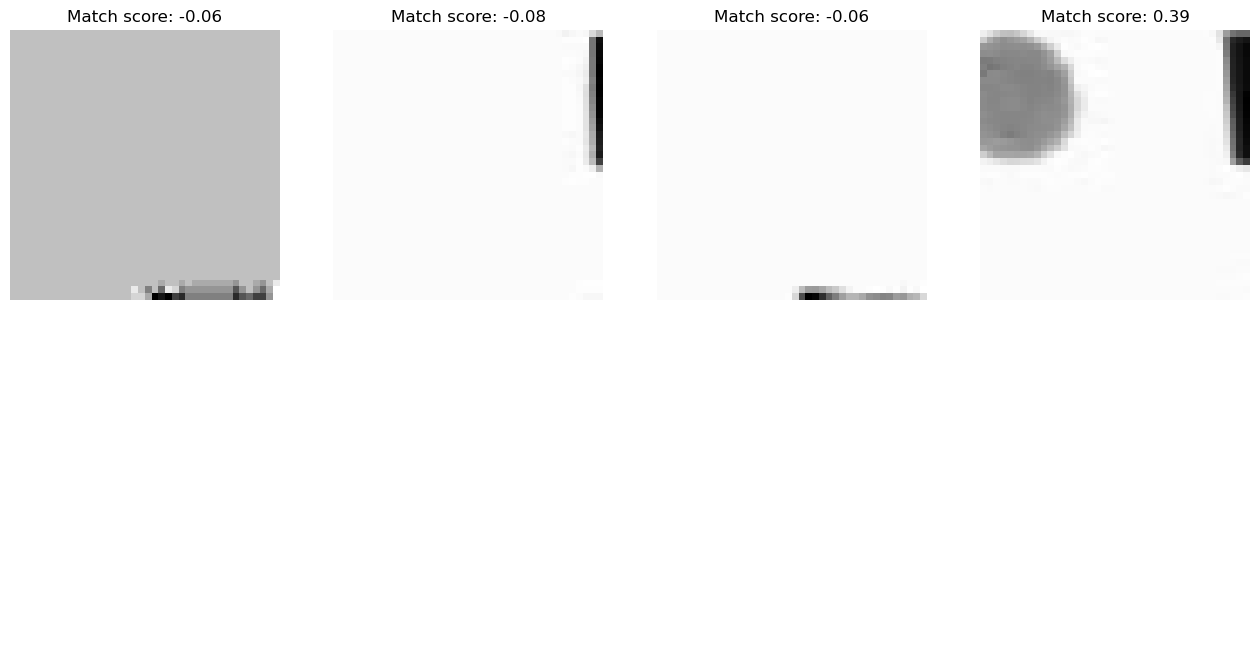

In [29]:
# plot all regions in a grid:
n_regions = len(regions)
n_cols = 4
n_rows = n_regions // n_cols + 1
f, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
for i, ax in enumerate(axs.flat):
    if i < n_regions:
        ax.imshow(regions[i], cmap="gray")
        ax.set_title(f"Match score: {match_scores[i]:.2f}")
    ax.axis("off")


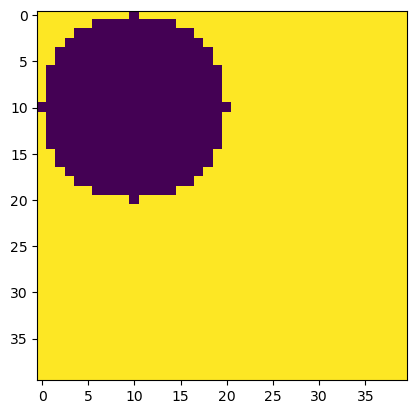

In [87]:
plt.figure()
plt.imshow(template)

In [56]:
image = image_array[0]
subpix_winSize=(5, 5)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = (
    cv2.CALIB_CB_FAST_CHECK
    + cv2.CALIB_CB_ADAPTIVE_THRESH * adaptive_threshold
    + cv2.CALIB_CB_NORMALIZE_IMAGE * normalize_image
)

ret, corners_approx = cv2.findChessboardCorners(
    image, board_shape, flags
)

uvs = cv2.cornerSubPix(
            image, corners_approx, subpix_winSize, (-1, -1), criteria
        ).squeeze()

uvs, match_scores, _ = reorder_chessboard_corners(
                image, uvs, board_shape, 
            )

In [48]:
results = [detect_chessboard(image, board_shape=board_shape) for image in image_array]
# detect_chessboard(image_array])

In [49]:
results.index(None)

235